In [15]:
import pandas as pd
from pathlib import Path
from datetime import datetime
from hauptstimme.alignment.score_audio_alignment import align_score_audios, align_hauptstimme_annotations
from hauptstimme.utils import get_compressed_measure_map
from hauptstimme.constants import CORPUS_PATH

In [16]:
# score_mxl = f"{CORPUS_PATH}/Beethoven,_Ludwig_van/Symphony_No.2,_Op.36/1/Beethoven_Op.36_1.mxl"
score_mxl = f"{CORPUS_PATH}/Beach,_Amy/Symphony_in_E_minor_(Gaelic),_Op.32/4/Beach_Op.32_4.mxl"
score_path = Path(score_mxl)

In [17]:
# start_time = datetime.strptime("00:00:07", "%H:%M:%S").time()
# end_time = datetime.strptime("00:12:10", "%H:%M:%S").time()
# score_audio_files = [["RNS", "proofs_of_concept/RNS_Beethoven_Op.36_1.mp3", start_time, end_time]]
start_time = datetime.strptime("00:00:00", "%H:%M:%S").time()
end_time = datetime.strptime("00:09:37", "%H:%M:%S").time()
score_audio_files = [["Seattle", "proofs_of_concept/Seattle_Beach_Op.32_4.mp3", start_time, end_time]]

### Comparison of Hauptstimme annotations and video annotations:

In [18]:
from hauptstimme.compare_annotations import *
from hauptstimme.segmentation import get_seg_pts_vec, evaluate_seg_pts, plot_seg_pts_eval

In [19]:
# Get aligned Hauptstimme annotations
score_annotations = f"proofs_of_concept/{score_path.stem}_annotations_aligned.csv"
score_annotations_df = pd.read_csv(score_annotations)
# score_tstamp_col = "RNS_tstamp"
score_tstamp_col = "Seattle_tstamp"
score_annotation_col = "instrument"

# Get video annotations
# video_annotations = f"proofs_of_concept/RNS_{score_path.stem}.csv"
video_annotations = f"proofs_of_concept/Seattle_{score_path.stem}.csv"
video_annotations_df = pd.read_csv(video_annotations)
video_tstamp_col = "scene_start"
video_annotation_col = "focal_instrument"

# Get lightweight score data frame
score_lw = score_path.with_suffix(".csv").as_posix()
score_lw_df = pd.read_csv(score_lw)

# Get part relationships summary
score_summary = f"proofs_of_concept/{score_path.stem}_part_relations.csv"
score_summary_df = pd.read_csv(score_summary)

# Define what to round each timestamp to
round_to = 0.25
# Define the maximum timestamp of the video
max_tstamp = (end_time.hour*60 + end_time.minute) * 60 + end_time.second
# Define the tolerance when comparing timestamps
tau = 4     # Tolerance of 1 second

In [20]:
# Get a vector of the video annotations
video_annotations_df[video_annotation_col] = get_default_instrument_names(video_annotations_df[video_annotation_col])
video_annotations_vec = get_annotations_vec(video_annotations_df, video_tstamp_col, video_annotation_col, round_to, max_tstamp)

Compare the instruments:

In [21]:
# Initialise counts for matches and partial matches between the annotations
match = 0
partial = 0
no = 0
cant = 0

for i, video_annotation in enumerate(video_annotations_vec):
    if pd.isna(video_annotation) or video_annotation == "Conductor":
        cant += 1
    else:
        video_annotation = str(video_annotation)

        # Get timestamp
        tstamp = i*round_to
        # Get qstamp corresponding to timestamp
        qstamp = score_annotations_df[score_annotations_df[score_tstamp_col] <= tstamp].iloc[-1]["qstamp"]

        # Get the corresponding score part relationships summary row
        summary_row = score_summary_df[score_summary_df["qstamp_start"] == qstamp]

        # Get part relationships for the video annotation instrument
        instr_relations = ""
        for col in score_summary_df.columns:
            if video_annotation in col:
                part_relations = summary_row[col].item()
                if not pd.isna(part_relations):
                    instr_relations += part_relations
        
        if "Main Part" in instr_relations:
            match += 1
        elif "Main" in instr_relations:
            partial += 1
        else:
            no += 1

# Compute and display results
match_percent = match/len(video_annotations_vec) * 100
partial_percent = partial/len(video_annotations_vec) * 100
no_percent = no/len(video_annotations_vec) * 100
cant_percent = cant/len(video_annotations_vec) * 100
print("Match percentage:", match_percent)
print("Partial match percentage:", partial_percent)
print("No match percentage:", no_percent)
print("Can't match percentage:", cant_percent)

Match percentage: 18.741921585523478
Partial match percentage: 4.179233089185696
No match percentage: 28.220594571305472
Can't match percentage: 48.85825075398535


Compare the timestamps:

In [22]:
# Get vectors for the annotation segmentation points
haupt_seg_pts = score_annotations_df[score_tstamp_col]
haupt_seg_pts_vec = get_seg_pts_vec(haupt_seg_pts, round_to, max_tstamp)

video_seg_pts_vec = get_seg_pts_vec(video_annotations_df[video_tstamp_col], round_to, max_tstamp)

Hauptstimme points compared to video points:
P = 0.839;  R = 0.261;  F = 0.398


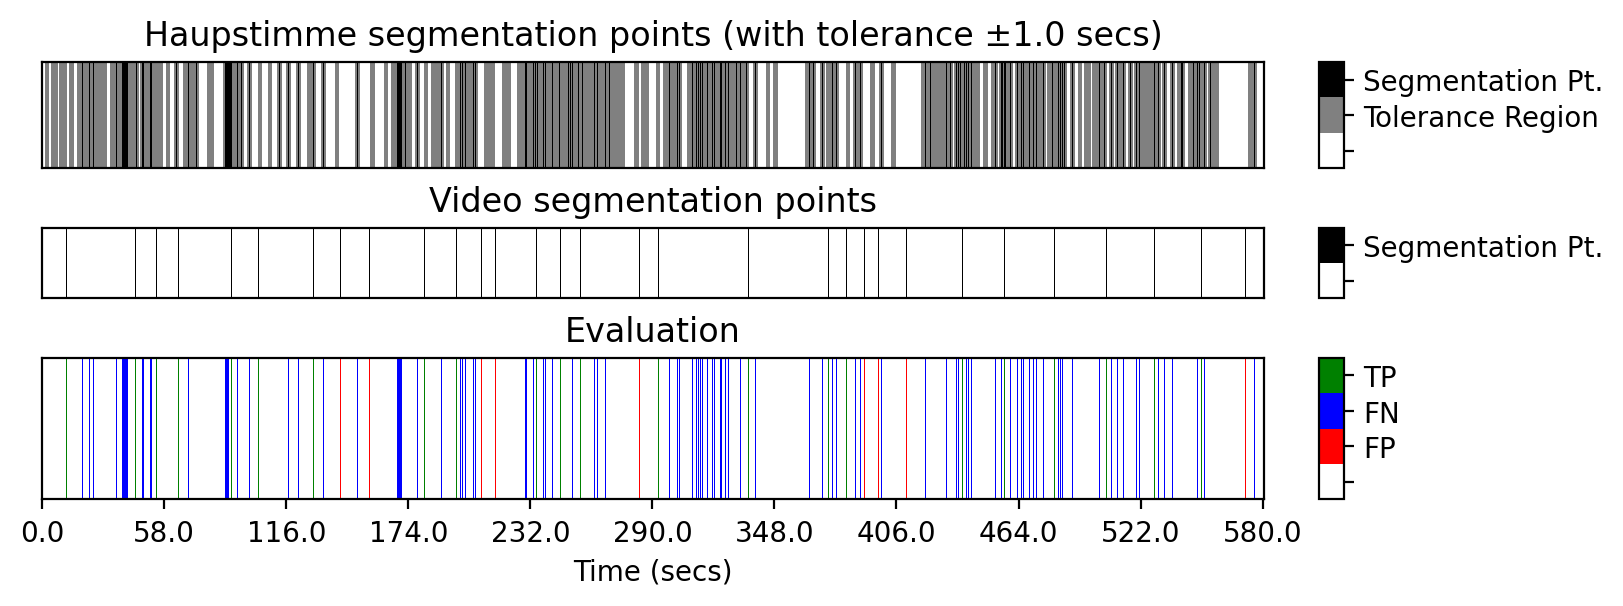

In [23]:
P, R, F, _, _, _, _, _ = evaluate_seg_pts(haupt_seg_pts_vec, video_seg_pts_vec, tau)
print("Hauptstimme points compared to video points:")
print("P = %0.3f;  R = %0.3f;  F = %0.3f" % (P, R, F))
fig, ax = plot_seg_pts_eval(haupt_seg_pts_vec, video_seg_pts_vec, tau,
                            round_to,
                            other_seg_pts=f"Video")